In [1]:
import pandas as pd

jobs_df = pd.read_csv('data/LinkedInJobs_MLDataset.csv')
jobs_df.head()

,Co_Nm,Co_Pg_Lstd,Emp_Cnt,Flw_Cnt,Job_Ttl,Job_Desc,Is_Supvsr,max_sal,med_sal,min_sal,...,st_code,is_remote,views,app_typ,app_is_off,xp_lvl,domain,has_post_domain,is_sponsored,base_comp
0,HearingLife,True,1171,11417,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,False,5250.00,5250.00,5250.00,...,SC,0,9,OffsiteApply,True,Entry level,careers-demant.icims.com,True,0,1
1,"Metalcraft of Mayville, Inc.",True,300,2923,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,False,0.00,0.00,0.00,...,WI,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,True,0,0
2,"U.S. Tsubaki Power Transmission, LLC",True,314,8487,"Manager, Engineering",The TSUBAKI name is synonymous with excellence...,True,0.00,0.00,0.00,...,AL,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,True,0,0
3,Episcopal Communities & Services,True,36,305,Cook,descriptionTitle\n\n Looking for a great oppor...,False,22.27,22.27,22.27,...,CA,0,1,OffsiteApply,True,Entry level,jobs.apploi.com,True,0,1
4,"iHerb, LLC",True,1227,51933,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",False,275834.00,240895.00,205956.00,...,XF,1,0,OffsiteApply,True,Mid-Senior level,careers.iherb.com,True,0,1


In [2]:
import spacy
import re
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')
jobs_df['Job_Desc'] = jobs_df['Job_Desc'].astype('str')
descriptions = [re.sub(r'[\d?,.;:!/-]', '', x).strip().lower() for x in jobs_df['Job_Desc'].values]
documents = list(tqdm(nlp.pipe(descriptions, n_process=12), total=len(descriptions)))

100%|██████████| 33246/33246 [04:38<00:00, 119.17it/s]


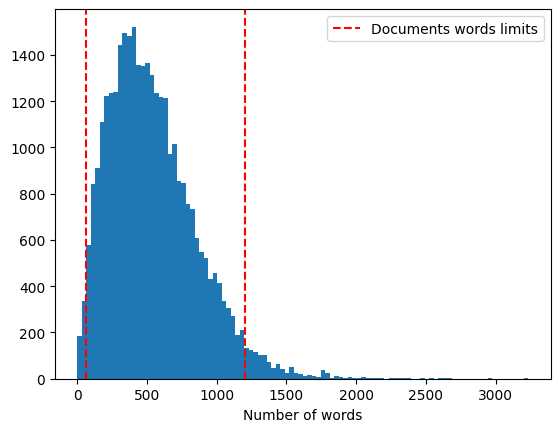

In [3]:
import matplotlib.pyplot as plt
from itertools import compress

min_words_limit = 60
max_words_limit = 1200
plt.hist([len(x) for x in documents], bins=100)
plt.axvline(min_words_limit, linestyle='dashed', c='r', label='Documents words limits')
plt.axvline(max_words_limit, linestyle='dashed', c='r')
plt.xlabel('Number of words')
plt.legend()
plt.show()

is_in_words_limit = [len(x) > min_words_limit and len(x) < max_words_limit for x in documents]
documents = list(compress(documents, is_in_words_limit))
jobs_df = jobs_df[is_in_words_limit]

In [4]:
from gensim.corpora import Dictionary
from spacy.lang.en.stop_words import STOP_WORDS

stop_words = list("\n firm type diploma closing date send level space job offer company firms oct connect jobs \
                  fcfa price spaces articles tax year cv job interview motivation letter advice questions mail \
                  work answers recruiters expired internship company send do activity sector have profile file \
                  company years address direction cv location benefit healthcare knowledge pet week gender status \
                  disability orientation color experience team include require skill ™ opportunity ability need ensure \
                  use care base pay position include requirement responsibility degree qualification member qualification \
                  apply application office candidate day make provide policy life applicant value part practice hour range \
                  area assign join relate change follow standard salary prefer function career regard field take age identity \
                  problem project service religion receive state tool description â€œhand".split())
stop_words += list(STOP_WORDS)
stop_words = set(stop_words)

texts = [[word.lemma_ for word in doc if (word.pos_ in ['NOUN', 'VERB']) and (word.lemma_ not in stop_words)] for doc in tqdm(documents)]

100%|██████████| 31675/31675 [00:07<00:00, 4038.65it/s]


Words count:  182235
Min word document popularity limit:  0.00041041831097079714


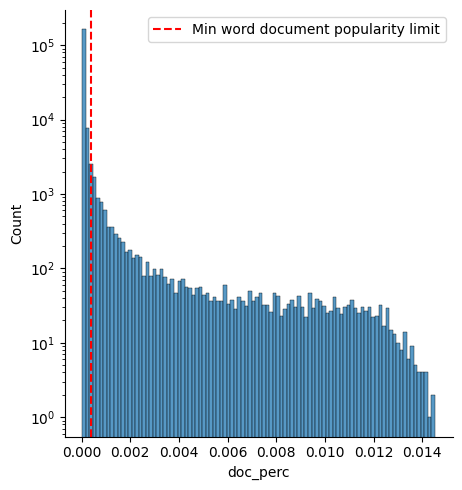

In [5]:
import seaborn as sns
import numpy as np

words_popularity_df = pd.DataFrame.from_records([{'id': i, 'word': word} for doc in texts for i, word in enumerate(doc)])
words_popularity_df = words_popularity_df.drop_duplicates(subset=['id', 'word'])
words_popularity_df = words_popularity_df.groupby(['word']).count().sort_values(by='id', ascending=False)
words_popularity_df['doc_perc'] = words_popularity_df['id'] / len(texts)

n_words_to_keep = 10000
min_doc_perc_limit = words_popularity_df['doc_perc'].quantile(1 - n_words_to_keep/len(words_popularity_df))
print('Words count: ', len(words_popularity_df))
print('Min word document popularity limit: ', min_doc_perc_limit)
sns.displot(words_popularity_df, x='doc_perc', bins=100)
plt.axvline(min_doc_perc_limit, linestyle='dashed', c='r', label='Min word document popularity limit')
plt.yscale('log')
plt.legend()
plt.show()

In [6]:
words_to_keep = set(words_popularity_df[words_popularity_df['doc_perc'] >= min_doc_perc_limit].index.values)
texts = [[word for word in doc if word in words_to_keep] for doc in tqdm(texts)]
dictionary = Dictionary(tqdm(texts))
corpus = [dictionary.doc2bow(text) for text in tqdm(texts)]

100%|██████████| 31675/31675 [00:02<00:00, 11179.26it/s]


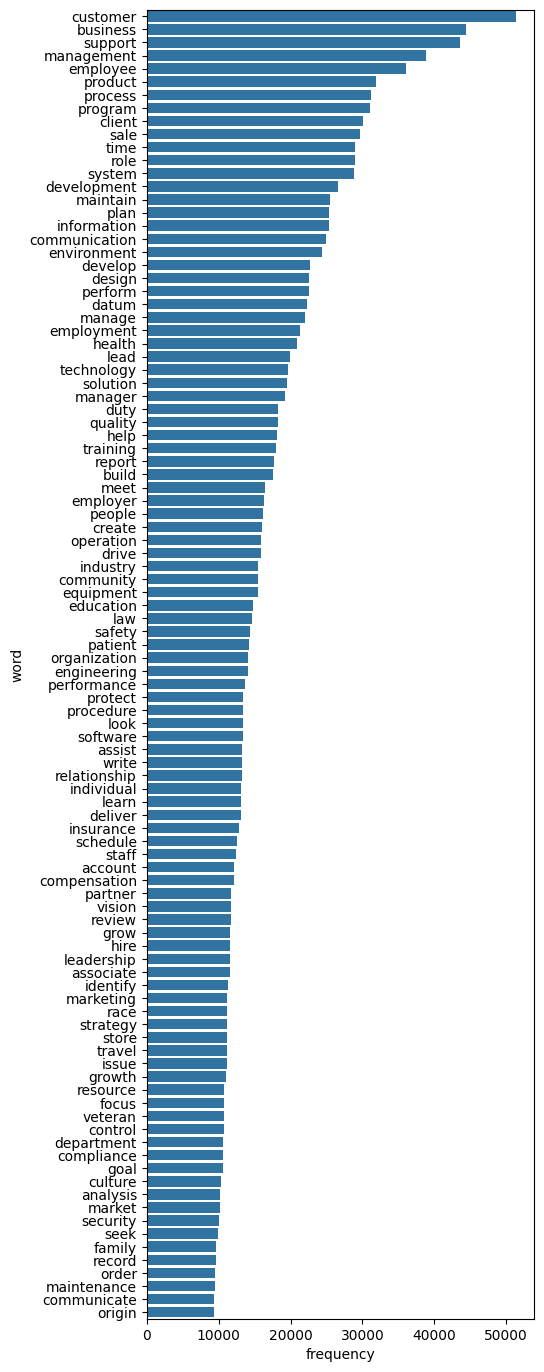

In [7]:
import pandas as pd

bag_of_words_df = pd.DataFrame.from_records([{'word': dictionary[id], 'frequency': freq, 'id': i} for doc in corpus for i, (id, freq) in enumerate(doc)])
bag_of_words_df = bag_of_words_df.groupby('word').sum().sort_values('frequency', ascending=False)
bag_of_words_df.reset_index(inplace=True)

plt.figure(figsize=(5, 17))
sns.barplot(x='frequency', y='word', data=bag_of_words_df.head(100))
plt.show()

100%|██████████| 8/8 [02:27<00:00, 18.46s/it]


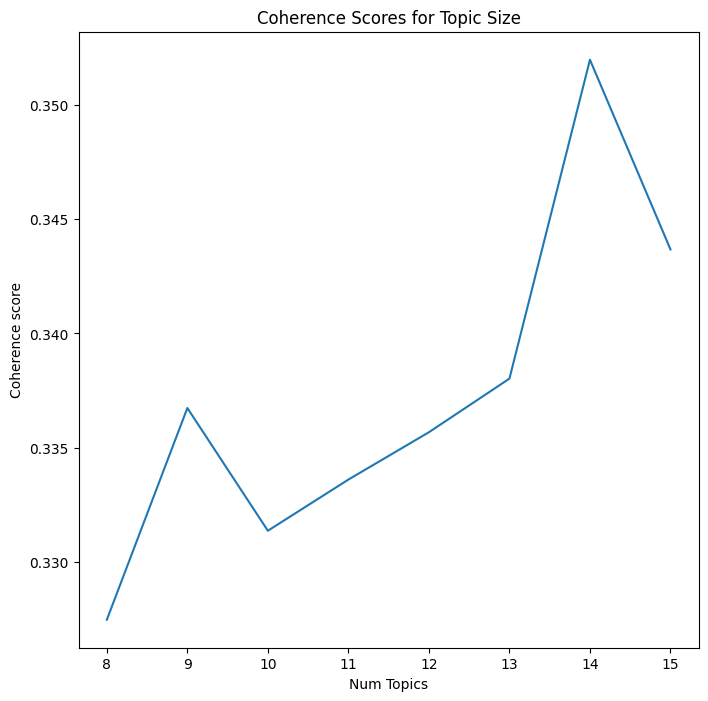

In [8]:
import matplotlib.pyplot as plt

from gensim.models import LdaMulticore, CoherenceModel

def compute_lda(corpus, dictionary, texts, num_topics):
    coherence_values = []
    model_list = []
    
    for num_topics in tqdm(num_topics):
        lda_model = LdaMulticore(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics, 
                                random_state=123,
                                chunksize=100,
                                per_word_topics=True)
        model_list.append(lda_model)
        
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values
    
start=8; end=16; step=1
num_topics = list(range(start, end, step))
model_list, coherence_values = compute_lda(corpus, dictionary, texts, num_topics)

# Show graph
x = range(start, end, step)
ax = plt.subplots(figsize=(8,8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Coherence Scores for Topic Size')
plt.show()

In [9]:
import pyLDAvis
import pyLDAvis.gensim_models

coherence_values = np.array(coherence_values)
best_model_index = coherence_values.argmax()
best_model = model_list[best_model_index]
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_list[1], corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.060454  0.022353       1        1  19.091413
1      0.058493  0.008228       2        1  15.709325
0      0.039890 -0.005947       3        1  11.176290
8     -0.019094 -0.034029       4        1  11.149192
5     -0.035183  0.057834       5        1  10.904462
2     -0.077840 -0.047825       6        1  10.065176
3     -0.054661  0.027043       7        1   9.126828
7      0.049879 -0.042630       8        1   8.635834
6     -0.021939  0.014975       9        1   4.141479, topic_info=         Term          Freq         Total Category  logprob  loglift
133   patient  14655.000000  14655.000000  Default  30.0000  30.0000
164      sale  32532.000000  32532.000000  Default  29.0000  29.0000
204  customer  51338.000000  51338.000000  Default  28.0000  28.0000
296    design  22014.000000  22014.000000  Default  27.0000  27.0000
267     store  10816.000000  10816.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
136   perform    868.088488  22838.476195   Topic9  -5.5464  -0.0858
19   business   1002.853054  47843.725929   Topic9  -5.4021  -0.6810
113  maintain    867.509752  25418.017373   Topic9  -5.5471  -0.1935
142   product    874.778536  33419.592673   Topic9  -5.5388  -0.4588
249   process    866.624214  31697.613488   Topic9  -5.5481  -0.4153

[851 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1509      1  0.086989    =
1509      2  0.176395    =
1509      3  0.024164    =
1509      4  0.038662    =
1509      5  0.026580    =
...     ...       ...  ...
1856      5  0.007851    ‚
1856      6  0.023552    ‚
1856      7  0.003925    ‚
1856      8  0.751699    ‚
1856      9  0.001963    ‚

[4029 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 9, 6, 3, 4, 8, 7])